In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

# 0. 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv', index_col=0) # 코랩 사용 시 경로(/content/drive/My Drive/Colab Notebooks/) 추가
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv', index_col=0)
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission.csv', index_col=0)

# 2. Train 데이터의 타입을 Sample_submission에 대응하는 가변수 형태로 변환
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x : to_number(x, column_number))

# 3.모델에 적용할 데이터 셋 준비 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer

train_x = train.drop(columns=['type', 'type_num'], axis=1)
del train_x['fiberID']
train_y = train['type_num']
test_x = test
del test_x['fiberID']

train_x.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [0]:
# 간단한 이상치 제거

# 0.985,0.015
x = train_x.copy() 

down_quantiles = x.quantile(0.002) # 전처리 비율 조정
up_quantiles = x.quantile(0.998)

outliers_low = (x < down_quantiles)
outliers_high = (x > up_quantiles)

x[outliers_low] = np.nan
x.fillna(down_quantiles, inplace=True)

x[outliers_high] = np.nan
x.fillna(up_quantiles, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fc9034b70>,
      dtype=object)

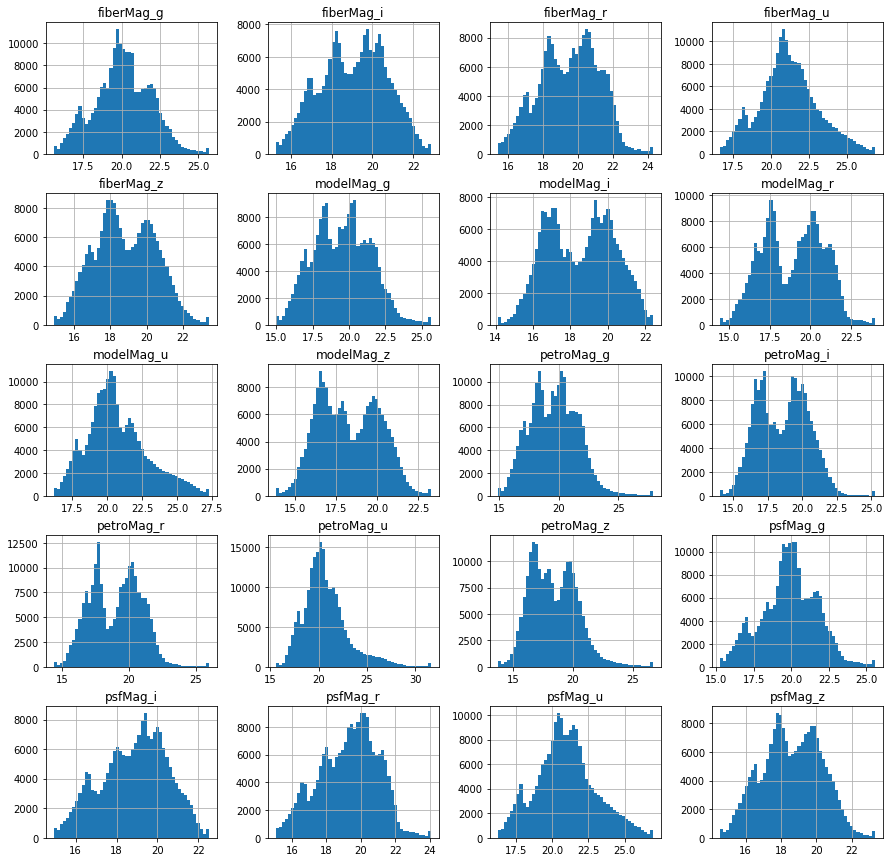

In [0]:
x.hist(bins=50, figsize=(15, 15))

In [0]:
x = x.values
train_y = train_y.values

x_train, x_val, y_train, y_val = train_test_split(x, train_y, train_size=0.9)

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
y_train = y_train.reshape(len(y_train), -1) 
y_val = y_val.reshape(len(y_val), -1)
y_train = onehot_encoder.fit_transform(y_train)
y_val = onehot_encoder.fit_transform(y_val)

print(x_train.shape)
print(y_train.shape)

(179991, 20)
(179991, 19)


In [0]:
# StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

# 4. 모델 생성하기
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras import regularizers, optimizers

model = Sequential()

model.add(Dense(128, input_shape=(20,))) #0.0007 # 정규화가 어느 정도 된 상태라서..?
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.07))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.07))
model.add(Dropout(0.45))
model.add(Dense(256))
model.add(BatchNormalization()) 
model.add(LeakyReLU(alpha=0.07))
model.add(Dropout(0.45))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.07))
model.add(Dropout(0.45))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.07))
model.add(Dropout(0.45))
model.add(Dense(19, activation='softmax'))


# 5. 모델 훈련시키기 
from keras.callbacks import EarlyStopping

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=800, mode='min')
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
hist = model.fit(x_train_scaled,y_train, epochs=5000, batch_size=256, validation_data = [x_val_scaled, y_val], callbacks=[early_stopping])

# # 6. 평가 검증하기
loss, acc = model.evaluate(x_val_scaled, y_val)
print('loss :', loss)
print('acc :', acc)

# 7. 예측
test_x_scaled = scaler.transform(test_x)
y_pred = model.predict(test_x_scaled)


# 8. 제출 파일 생성
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission(11).csv', index=True)


# early stopping patience 200 이상일 경우 overfitting
# Dropout 0.3 이하 overfitting 발생
# hidden layer 4개 이하 overfitting 발생
# node = 512일 경우 overfitting 발생

# 가장 기록 좋았을 때
# model = Sequential()

# model.add(Dense(128, input_shape=(20,)))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(Dropout(0.45))
# model.add(Dense(19, activation='softmax'))

Train on 179991 samples, validate on 20000 samples
Epoch 1/5000
179991/179991 [==============================] - 10s 56us/step - loss: 0.7729 - acc: 0.7593 - val_loss: 0.5777 - val_acc: 0.7882
Epoch 2/5000
179991/179991 [==============================] - 9s 50us/step - loss: 0.5836 - acc: 0.8105 - val_loss: 0.4881 - val_acc: 0.8338
Epoch 3/5000
179991/179991 [==============================] - 9s 49us/step - loss: 0.5509 - acc: 0.8177 - val_loss: 0.4731 - val_acc: 0.8374
Epoch 4/5000
179991/179991 [==============================] - 9s 50us/step - loss: 0.5297 - acc: 0.8235 - val_loss: 0.4564 - val_acc: 0.8400
Epoch 5/5000
179991/179991 [==============================] - 9s 51us/step - loss: 0.5195 - acc: 0.8266 - val_loss: 0.4578 - val_acc: 0.8420
Epoch 6/5000
179991/179991 [==============================] - 9s 51us/step - loss: 0.5090 - acc: 0.8295 - val_loss: 0.4621 - val_acc: 0.8404
Epoch 7/5000
179991/179991 [==============================] - 9s 51us/step - loss: 0.5017 - acc: 0.831

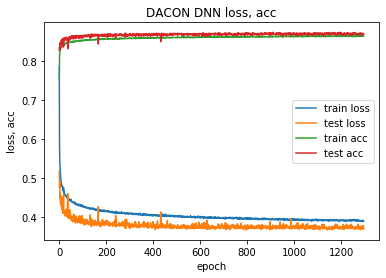

In [0]:
# matplotlib으로 보기
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('DACON DNN loss, acc')
plt.xlabel('epoch')
plt.ylabel('loss, acc')
plt.legend(['train loss', 'test loss', 'train acc', 'test acc'])
plt.show()

# First
# loss : 0.3751423681736819
# acc : 0.8720957365285246

# Second
# loss : 0.37057404349997003
# acc : 0.8689456582069397

# Third
# loss : 0.36412223417814554
# acc : 0.8720468282699585

# Fourth
# loss: 0.3597

# Fifth
# loss: 

# 최소 0.35~0.33까지 떨어뜨려야 함
# 참고 epoch 30% = earlystopping